# Phase 3 Data Science Training Example as Reference Notebook

Goal: Classify all wearables.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

## Exploratory Data Analysis

### Opening the datasets.

In [2]:
import gzip

train_data_zip = gzip.open("data/train-images-idx3-ubyte.gz")
train_label_zip = gzip.open("data/train-labels-idx1-ubyte.gz")

test_data_zip = gzip.open("data/t10k-images-idx3-ubyte.gz")
test_label_zip = gzip.open("data/t10k-labels-idx1-ubyte.gz")

# Exclude metadata.
train_data_zip.read(16)
test_data_zip.read(16)
train_label_zip.read(8)
test_label_zip.read(8)

b"\x00\x00\x08\x01\x00\x00'\x10"

In [3]:
img_size = 28
number_img = 60000

buf = train_data_zip.read(number_img * img_size * img_size)

train_img = np.frombuffer(buf, dtype=np.uint8)
train_img = train_img.reshape(number_img, img_size, img_size)

train_img.shape

# There is 60000 entries in a training image set and each entry is assumed to take the 2D array shape of 28x28.

(60000, 28, 28)

In [4]:
buf = train_label_zip.read(number_img)

train_label = np.frombuffer(buf, dtype=np.uint8)
train_label = train_label.reshape(number_img)

train_label.shape

# There is 60000 entries in a training label set and each entry is a category number.

(60000,)

In [5]:
number_img = 10000

buf = test_data_zip.read(number_img * img_size * img_size)

test_img = np.frombuffer(buf, dtype=np.uint8)
test_img = test_img.reshape(number_img, img_size, img_size)

test_img.shape

# There is 10000 entries in a testing image set and each entry is assumed to take the 2D array shape of 28x28.

(10000, 28, 28)

In [6]:
buf = test_label_zip.read(number_img)

test_label = np.frombuffer(buf, dtype=np.uint8)
test_label = test_label.reshape(number_img)

test_label.shape

# There is 10000 entries in a testing label set and each entry is a category number.

(10000,)

In [7]:
train_img.max()

255

In [8]:
train_img.min()

0

### Image render.

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [9]:
np.unique(train_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [10]:
np.unique(test_label, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

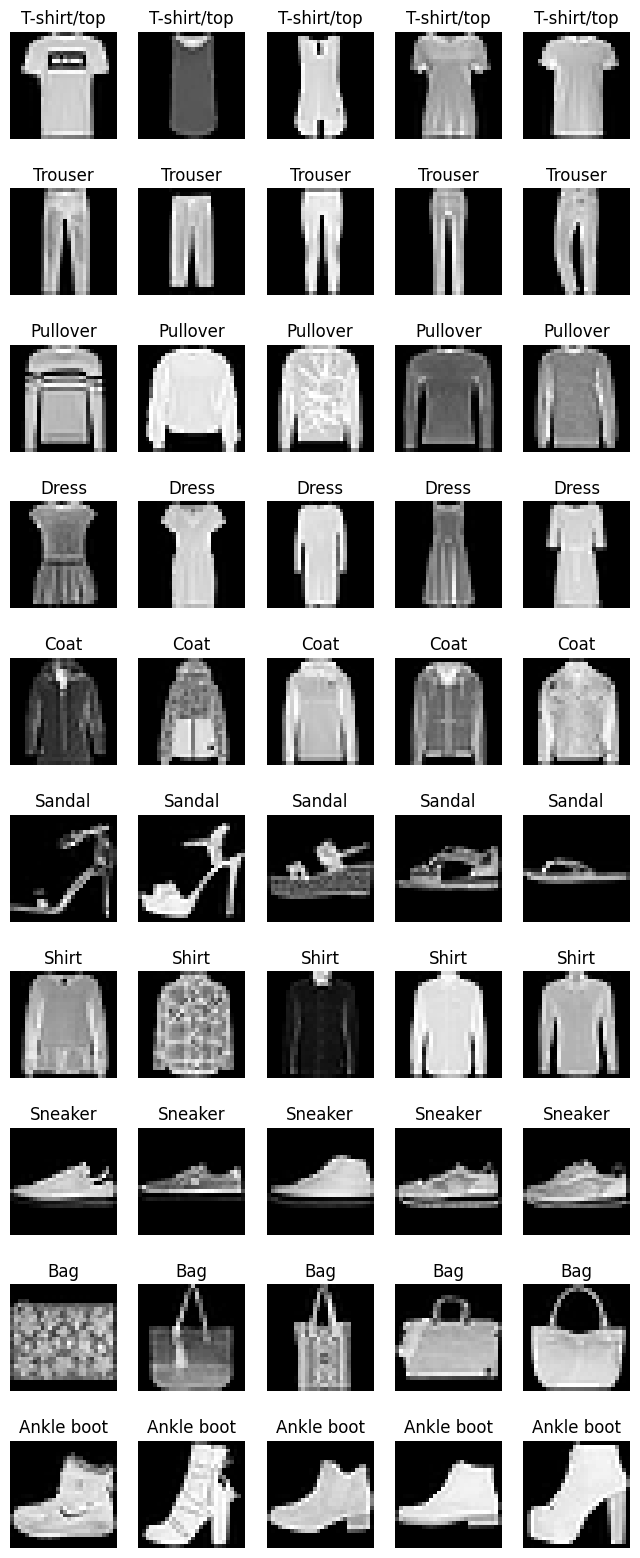

In [11]:
import matplotlib.pyplot as plt

label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(8, 20))

for label in range(10): # Does not include 10.
    search_results = np.where(train_label == label)[0][:5]

    for index, img_index in enumerate(search_results):
        current_index = label * 5 + index + 1
        ax = plt.subplot(10,5, current_index)
        plt.imshow(train_img[img_index], cmap="gray")
        plt.title(label_names[label])
        plt.axis("off")

# Ensure I loaded the dataset correctly.

There is a good balance on the number of labelled images. The maximum value of the image is 255 and the minimum is 0 as usual since the data type is `uint8`. We can normalise the dataset to reduce the drasticness of the difference when the model is being trained. There is only 1 color layer so the safe assumption is that the images used here will be greyscale.

# Data Processing

I choose to filter bag since does not count as clothing. Also bag is just an accessory.

In [12]:
# 8 is the label for bag, remove this for the goal.

filter_train_arr = [label != 8 for label in train_label]
filter_test_arr = [label != 8 for label in test_label]

train_label_filtered = train_label[filter_train_arr]
np.unique(train_label_filtered, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [13]:
test_label_filtered = test_label[filter_test_arr]
np.unique(test_label_filtered, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [14]:
train_image_filtered = train_img[filter_train_arr]
train_label_filtered.shape

(54000,)

In [15]:
test_image_filtered = test_img[filter_test_arr]
test_label_filtered.shape

(9000,)

In [16]:
# Convert all the entries with 9 as value to 8 since Ankle boot is now 8 instead of bag.

filter_train_arr = [label == 9 for label in train_label_filtered]
filter_test_arr = [label == 9 for label in test_label_filtered]

train_label_filtered[filter_train_arr] = 8
np.unique(train_label_filtered, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [17]:
test_label_filtered[filter_test_arr] = 8
np.unique(test_label_filtered, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [18]:
train_x = train_image_filtered
train_y = np.array([[int(i == label_index) for i in range(9)] for label_index in train_label_filtered])

test_x = test_image_filtered
test_y = np.array([[int(i == label_index) for i in range(9)] for label_index in test_label_filtered])

In [19]:
# Ensure the y outputs is an array of 9 numbers labelled from 0 to 8 both inclusive.

train_y.shape

(54000, 9)

In [20]:
train_y[3]

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

In [21]:
test_y.shape

(9000, 9)

In [22]:
test_y[3]

array([0, 1, 0, 0, 0, 0, 0, 0, 0])

# Data Modelling

In [23]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime

In [24]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Classification_Model")
    model.add(Input(shape=(28,28,))) # Input layer.

    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Convert range from 0-255 to 0-1.

    model.add(layers.Flatten()) # Make a 2D array to 1D array.

    # The model shape below is just an arbitary choice of mine. May not be the overall best choice.
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(rate=0.3))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate=0.5))

    model.add(layers.Dense(9, activation="softmax", name="Output_Probability")) # Output layer.

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.000005), # Optimisation for model, includes annotating learning rate.
        loss=losses.BinaryCrossentropy(), # Loss metric.
        metrics=['accuracy']
    )

    return model

In [25]:
model = generateModel()

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=50000,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    verbose=0 # You can see model performance in tensorboard. Remove this line if you prefer logs in notebook :)
)

2022-08-18 00:10:24.462923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:10:24.493520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:10:24.493733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:10:24.494315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [26]:
model.save('output/my_model')

INFO:tensorflow:Assets written to: output/my_model/assets
